In [2]:
import numpy as np 
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt 
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import os
import shutil
from tensorflow.keras import metrics
import matplotlib
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import SGD, RMSprop
plt.style.use('seaborn')


# Create X and y Data: Helper Functions

* create_X_and_y()

In [3]:
def create_X_and_y(X_filepath, y_filepath):
    
    ''' imports lined images and unlined images from jpeg files 
    into numpy arrays for use into autoencoder'''
    
    y_list = []
    for image in sorted(os.listdir(y_filepath)):
        file= y_filepath + str(image)
        y_image = np.array(Image.open(file))
        y_image = y_image.reshape(*y_image.shape,1)
        y_list.append(y_image)
                    
    y = np.array(y_list)  

    X_list = []
    for image in sorted(os.listdir(X_filepath)):
        file = X_filepath+str(image)
        X_image = np.array(Image.open(file))
        X_image = X_image.reshape(*X_image.shape,1)
        X_list.append(X_image)
        
    X = np.array(X_list)
    
    return X,y

In [4]:
'''Create the data X,y '''
y_filepath = 'Data/y_variables/Unruled/'
X_filepath = 'Data/X_variables/computer_generated_lines/'

X,y = create_X_and_y(X_filepath, y_filepath)
X.shape, y.shape

((669, 500, 400, 1), (669, 500, 400, 1))

# Model Setup: Helper Functions
* model:
    create_and_compile()
    fit_model()
    predict()
    
* plot:
    plot_loss()
    plot_accuracy()


In [5]:
def callbacks(model_name = 'model', early_stopping = False, patience = None):
    checkpoint_filepath = (f'./tmp/{model_name}/checkpoint')
    tensorboard = TensorBoard(log_dir=(f"./logs/{model_name}"),
                            
                            histogram_freq=2,
                            write_graph=True,
                            write_images=True,
                            update_freq="epoch",
                            profile_batch=2,
                            embeddings_freq=0,
                            embeddings_metadata=None)
    if early_stopping == True:
        early_stopping = EarlyStopping(monitor='loss',  patience=patience, restore_best_weights=True)
    model_cp = ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'loss', save_best_only=True)
    
    return tensorboard, early_stopping, model_cp



In [6]:
def create_and_compile_sparse_model(optimizer='adam', learning_rate=.001, loss='mse', metrics='accuracy'):
    ''' creates and compiles model '''
    
    input_img = Input(shape=(500,400,1)) 
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = Dense(128)(x) 
    x= Conv2DTranspose(32,(3,3), activation='relu')(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='linear', padding='same')(x)

    compile_optimizer = Adam(learning_rate=learning_rate)#if ever use different than Adam will need to change this line
    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer=compile_optimizer, loss=loss, metrics=metrics)
    return autoencoder

In [7]:
def sequential_model(loss = 'mse', optimizer = 'adam', metrics=['accuracy']):
    '''creates and compiles a simple Sequential Model.'''
    
    model = Sequential()
    model.add(Input(shape=(500,400,1)))
  
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))

    model.add(Dense(128,  activation='relu'))
    model.add(Dense(2,    activation='linear', name="bottleneck"))
    model.add(Dense(128,  activation='relu'))

    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 1, kernel_size=(3,3), activation='linear', padding='same'))

    model.summary()
    
    model.compile(loss = loss, optimizer = optimizer, metrics=metrics) 
    #does Saquential have a compile optimizer?
    return model




In [8]:
def fit_model(compiled_model, x=X, y=y, batch_size=15, epochs=50, verbose=1, callbacks=None, validation_split=0.2):

    history = compiled_model.fit(x=X, y=y, batch_size=batch_size, epochs = epochs, verbose=verbose, callbacks=callbacks, validation_split=validation_split)
    return history

In [9]:
def plot_loss(model_name, model_history, metric_1 = 'loss', color_1='blue', metric_1_label = 'Training Loss Score by Epoch', 
                 metric_2 = 'val_loss', color_2='green', metric_2_label = 'Validation Loss Score by Epoch'):
    
    plt.plot(model_history.history[metric_1], color=color_1, label=metric_1_label)
    plt.plot(model_history.history[metric_2], color=color_2, label=metric_2_label)
    plt.title(label=model_name)
    plt.legend()


In [10]:
def plot_accuracy(model_name, model_history, metric_3 = 'accuracy', color_3='red', metric_3_label = 'Training Accuracy Score by Epoch', 
                 metric_4 = 'val_accuracy', color_4='orange', metric_4_label = 'Validation Accuracy Score by Epoch'):
    
    plt.plot(model_history.history[metric_3], color=color_3, label=metric_3_label)
    plt.plot(model_history.history[metric_4], color=color_4, label=metric_4_label)
    plt.title(label=model_name)
    plt.legend()

In [11]:
def predict_image_on_X(fitted_model, X=X, index=0):
    result = fitted_model.predict(X)
    result[result>255]=255
    result[result<0] = 0
    result = result[index].astype(np.uint8).reshape(500,400)
    original = X[index].astype(np.uint8).reshape(500,400)
    
    return Image.fromarray(np.hstack([original, result]))

In [12]:
def predict_on_unseen(fitted_model, file_path_list):
    
    '''Removes the lines on images that the model has NOT seen. To see the images index into list that is returned.''' 
    
    
    if len(file_path_list)== 1:
        image_to_predict = np.array(Image.open(str(file_path_list)))
        result = fitted_model.predict(np.array([image_to_predict.reshape(*image_to_predict.shape, 1)]))
        result[result>255]=255
        result[result<0] = 0
        result = result.astype(np.uint8).reshape(500,400)
        return Image.fromarray(np.hstack([image_to_predict, result]))
                                    
    else:
        original_image_list = []
        result_image_list = []
        difference_list = []
        for idx, original_image in enumerate(file_path_list):
            original_image = np.array(Image.open(str(file_path_list[idx])))
            original_image_list.append(original_image)
                                      
            result = fitted_model.predict(np.array([original_image.reshape(*original_image.shape, 1)]))
            result[result>255]=255
            result[result<0] = 0
            result = result.astype(np.uint8).reshape(500,400)
            result_image_list.append(result)
            difference_list.append(result - original_image)
        all_results_list=[]
        for idx, images in enumerate(zip(original_image_list, result_image_list, difference_list)):
            all_results_list.append(Image.fromarray(np.hstack([original_image_list[idx], result_image_list[idx], difference_list[idx]])))
        return all_results_list


In [13]:
def open_saved_model(model_name):
    model = load_model(f'./tmp/{model_name}/checkpoint', custom_objects=None,
                       compile=True, options=None)
    return model
                       
                       
    #/home/ubuntu/Capstone_3/tmp/checkpoint/saved_model.pb
    #full filepath as an example

# The Models w/ Results

### Model Type 1: Sparse


In [151]:
#set up model callbacks
tensorboard, early_stopping, model_cp = callbacks(model_name = 'sparse_3', 
                                                  early_stopping = True, patience = 15)

#create and compile model
sparse_3 = create_and_compile_sparse_model(optimizer='adamax', learning_rate=.0001, 
                                           loss='mse', metrics='accuracy')

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 500, 400, 1)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 498, 398, 32)      320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 498, 398, 8)       2312      
_________________________________________________________________
dense_8 (Dense)              (None, 498, 398, 128)     1152      
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 500, 400, 32)      36896     
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 500, 400, 1)       289       
Total params: 40,969
Trainable params: 40,969
Non-trainable params: 0
__________________________________________________

In [152]:
sparse_3_history = fit_model(sparse_3, x=X, y=y, batch_size=15, epochs=5000, 
                             verbose=1, callbacks=[tensorboard,early_stopping,model_cp], 
                             validation_split=0.2)




Epoch 1/5000
36/36 [==============================] - 5s 135ms/step - loss: 31654.4980 - accuracy: 4.3925e-06 - val_loss: 3819.1667 - val_accuracy: 9.7388e-06
Epoch 2/5000
36/36 [==============================] - 5s 126ms/step - loss: 1162.9769 - accuracy: 4.2617e-06 - val_loss: 733.0922 - val_accuracy: 9.7388e-06
Epoch 3/5000
36/36 [==============================] - 5s 126ms/step - loss: 613.0595 - accuracy: 4.2617e-06 - val_loss: 613.6839 - val_accuracy: 9.7388e-06
Epoch 4/5000
36/36 [==============================] - 5s 126ms/step - loss: 577.3755 - accuracy: 4.2617e-06 - val_loss: 597.7348 - val_accuracy: 9.7388e-06
Epoch 5/5000
36/36 [==============================] - 5s 134ms/step - loss: 555.9484 - accuracy: 4.2617e-06 - val_loss: 571.7076 - val_accuracy: 9.7388e-06
Epoch 6/5000
36/36 [==============================] - 5s 127ms/step - loss: 528.2982 - accuracy: 4.2617e-06 - val_loss: 539.1069 - val_accuracy: 9.7388e-06
Epoch 7/5000
36/36 [==============================] - 5s 128

36/36 [==============================] - 5s 129ms/step - loss: 49.1245 - accuracy: 7.9065e-06 - val_loss: 50.1061 - val_accuracy: 1.9701e-05
Epoch 27/5000
36/36 [==============================] - 5s 129ms/step - loss: 45.5132 - accuracy: 8.1495e-06 - val_loss: 46.3526 - val_accuracy: 1.9813e-05
Epoch 28/5000
36/36 [==============================] - 5s 136ms/step - loss: 42.4964 - accuracy: 8.3178e-06 - val_loss: 43.7607 - val_accuracy: 1.9776e-05
Epoch 29/5000
36/36 [==============================] - 5s 129ms/step - loss: 40.0542 - accuracy: 8.5607e-06 - val_loss: 41.2171 - val_accuracy: 1.9888e-05
Epoch 30/5000
36/36 [==============================] - 5s 128ms/step - loss: 37.9385 - accuracy: 8.6636e-06 - val_loss: 39.1812 - val_accuracy: 2.0112e-05
Epoch 31/5000
36/36 [==============================] - 5s 129ms/step - loss: 36.4091 - accuracy: 8.6262e-06 - val_loss: 37.5659 - val_accuracy: 2.0709e-05
Epoch 32/5000
36/36 [==============================] - 5s 129ms/step - loss: 34.7327

Epoch 53/5000
36/36 [==============================] - 5s 129ms/step - loss: 22.0062 - accuracy: 1.3654e-05 - val_loss: 23.1591 - val_accuracy: 2.8955e-05
Epoch 54/5000
36/36 [==============================] - 5s 129ms/step - loss: 21.6728 - accuracy: 1.3065e-05 - val_loss: 22.9913 - val_accuracy: 2.7761e-05
Epoch 55/5000
36/36 [==============================] - 5s 130ms/step - loss: 21.6258 - accuracy: 1.3626e-05 - val_loss: 22.6254 - val_accuracy: 2.8022e-05
Epoch 56/5000
36/36 [==============================] - 5s 128ms/step - loss: 21.2526 - accuracy: 1.2916e-05 - val_loss: 22.6525 - val_accuracy: 2.9291e-05
Epoch 57/5000
36/36 [==============================] - 5s 129ms/step - loss: 21.1615 - accuracy: 1.3206e-05 - val_loss: 22.2137 - val_accuracy: 2.8209e-05
Epoch 58/5000
36/36 [==============================] - 5s 128ms/step - loss: 20.7879 - accuracy: 1.3682e-05 - val_loss: 22.1957 - val_accuracy: 2.7239e-05
Epoch 59/5000
36/36 [==============================] - 5s 137ms/step -

Epoch 82/5000
36/36 [==============================] - 5s 129ms/step - loss: 17.4948 - accuracy: 1.3813e-05 - val_loss: 18.6472 - val_accuracy: 3.0000e-05
Epoch 83/5000
36/36 [==============================] - 4s 105ms/step - loss: 17.7484 - accuracy: 1.4028e-05 - val_loss: 19.2768 - val_accuracy: 3.0336e-05
Epoch 84/5000
36/36 [==============================] - 5s 129ms/step - loss: 17.3537 - accuracy: 1.4355e-05 - val_loss: 19.1433 - val_accuracy: 3.0858e-05
Epoch 85/5000
36/36 [==============================] - 4s 105ms/step - loss: 17.4242 - accuracy: 1.3486e-05 - val_loss: 18.4547 - val_accuracy: 2.8843e-05
Epoch 86/5000
36/36 [==============================] - 4s 105ms/step - loss: 17.4165 - accuracy: 1.3897e-05 - val_loss: 20.2393 - val_accuracy: 2.6381e-05
Epoch 87/5000
36/36 [==============================] - 4s 105ms/step - loss: 17.5052 - accuracy: 1.3738e-05 - val_loss: 18.0763 - val_accuracy: 2.8843e-05
Epoch 88/5000
36/36 [==============================] - 5s 129ms/step -

Epoch 115/5000
36/36 [==============================] - 5s 130ms/step - loss: 15.3197 - accuracy: 1.2383e-05 - val_loss: 16.3355 - val_accuracy: 2.8433e-05
Epoch 116/5000
36/36 [==============================] - 4s 104ms/step - loss: 15.3947 - accuracy: 1.3290e-05 - val_loss: 16.3293 - val_accuracy: 2.8433e-05
Epoch 117/5000
36/36 [==============================] - 5s 129ms/step - loss: 15.1824 - accuracy: 1.3514e-05 - val_loss: 16.2834 - val_accuracy: 2.9440e-05
Epoch 118/5000
36/36 [==============================] - 4s 104ms/step - loss: 15.1985 - accuracy: 1.3626e-05 - val_loss: 16.5308 - val_accuracy: 2.8246e-05
Epoch 119/5000
36/36 [==============================] - 5s 137ms/step - loss: 15.1797 - accuracy: 1.2860e-05 - val_loss: 16.2670 - val_accuracy: 3.0522e-05
Epoch 120/5000
36/36 [==============================] - 4s 104ms/step - loss: 15.3483 - accuracy: 1.2421e-05 - val_loss: 16.6459 - val_accuracy: 3.2127e-05
Epoch 121/5000
36/36 [==============================] - 4s 105ms

Epoch 150/5000
36/36 [==============================] - 5s 137ms/step - loss: 13.9777 - accuracy: 1.3673e-05 - val_loss: 15.5894 - val_accuracy: 3.0448e-05
Epoch 151/5000
36/36 [==============================] - 4s 105ms/step - loss: 14.1181 - accuracy: 1.2121e-05 - val_loss: 15.0285 - val_accuracy: 3.0112e-05
Epoch 152/5000
36/36 [==============================] - 4s 104ms/step - loss: 14.5015 - accuracy: 1.2879e-05 - val_loss: 15.6272 - val_accuracy: 3.1978e-05
Epoch 153/5000
36/36 [==============================] - 4s 105ms/step - loss: 14.2460 - accuracy: 1.3860e-05 - val_loss: 15.7997 - val_accuracy: 2.6828e-05
Epoch 154/5000
36/36 [==============================] - 4s 104ms/step - loss: 14.0931 - accuracy: 1.2935e-05 - val_loss: 15.4140 - val_accuracy: 2.8731e-05
Epoch 155/5000
36/36 [==============================] - 4s 105ms/step - loss: 14.2153 - accuracy: 1.2570e-05 - val_loss: 14.8776 - val_accuracy: 3.0746e-05
Epoch 156/5000
36/36 [==============================] - 4s 104ms

Epoch 193/5000
36/36 [==============================] - 4s 105ms/step - loss: 13.3203 - accuracy: 1.4009e-05 - val_loss: 16.3764 - val_accuracy: 3.3284e-05
Epoch 194/5000
36/36 [==============================] - 4s 104ms/step - loss: 13.2464 - accuracy: 1.3879e-05 - val_loss: 13.7472 - val_accuracy: 3.0522e-05
Epoch 195/5000
36/36 [==============================] - 5s 130ms/step - loss: 12.8428 - accuracy: 1.3178e-05 - val_loss: 13.7722 - val_accuracy: 3.2873e-05
Epoch 196/5000
36/36 [==============================] - 4s 105ms/step - loss: 12.9887 - accuracy: 1.3785e-05 - val_loss: 13.6832 - val_accuracy: 3.2052e-05
Epoch 197/5000
36/36 [==============================] - 4s 105ms/step - loss: 12.8770 - accuracy: 1.3178e-05 - val_loss: 13.7881 - val_accuracy: 3.0784e-05
Epoch 198/5000
36/36 [==============================] - 4s 104ms/step - loss: 12.9551 - accuracy: 1.4028e-05 - val_loss: 13.6859 - val_accuracy: 3.3246e-05
Epoch 199/5000
36/36 [==============================] - 5s 130ms

Epoch 272/5000
36/36 [==============================] - 4s 105ms/step - loss: 11.4881 - accuracy: 1.3439e-05 - val_loss: 13.3490 - val_accuracy: 4.2090e-05
Epoch 273/5000
36/36 [==============================] - 4s 105ms/step - loss: 11.3429 - accuracy: 1.8327e-05 - val_loss: 11.9816 - val_accuracy: 3.0336e-05
Epoch 274/5000
36/36 [==============================] - 4s 105ms/step - loss: 11.2010 - accuracy: 1.5140e-05 - val_loss: 12.0421 - val_accuracy: 3.4104e-05
Epoch 275/5000
36/36 [==============================] - 5s 130ms/step - loss: 10.9247 - accuracy: 1.4897e-05 - val_loss: 12.0193 - val_accuracy: 3.6269e-05
Epoch 276/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.9759 - accuracy: 1.5486e-05 - val_loss: 11.8421 - val_accuracy: 3.7500e-05
Epoch 277/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.9390 - accuracy: 1.4682e-05 - val_loss: 12.0632 - val_accuracy: 3.4179e-05
Epoch 278/5000
36/36 [==============================] - 5s 130ms

36/36 [==============================] - 5s 130ms/step - loss: 9.8518 - accuracy: 1.4290e-05 - val_loss: 11.2106 - val_accuracy: 3.1306e-05
Epoch 354/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.1546 - accuracy: 1.4234e-05 - val_loss: 10.7662 - val_accuracy: 3.4963e-05
Epoch 355/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.0876 - accuracy: 1.3467e-05 - val_loss: 11.0231 - val_accuracy: 3.9739e-05
Epoch 356/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.3809 - accuracy: 1.4738e-05 - val_loss: 10.6778 - val_accuracy: 3.2985e-05
Epoch 357/5000
36/36 [==============================] - 5s 130ms/step - loss: 9.8173 - accuracy: 1.4290e-05 - val_loss: 10.6930 - val_accuracy: 3.5037e-05
Epoch 358/5000
36/36 [==============================] - 5s 129ms/step - loss: 9.7705 - accuracy: 1.4121e-05 - val_loss: 10.7783 - val_accuracy: 3.2425e-05
Epoch 359/5000
36/36 [==============================] - 4s 106ms/step - loss: 9.84

Epoch 397/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.5562 - accuracy: 1.4673e-05 - val_loss: 10.3558 - val_accuracy: 3.1828e-05
Epoch 398/5000
36/36 [==============================] - 5s 129ms/step - loss: 9.3775 - accuracy: 1.3766e-05 - val_loss: 10.3653 - val_accuracy: 3.2090e-05
Epoch 399/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.5841 - accuracy: 1.3477e-05 - val_loss: 10.3295 - val_accuracy: 3.3022e-05
Epoch 400/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.4574 - accuracy: 1.4168e-05 - val_loss: 10.2982 - val_accuracy: 3.2612e-05
Epoch 401/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.5284 - accuracy: 1.4673e-05 - val_loss: 10.8999 - val_accuracy: 3.2910e-05
Epoch 402/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.5440 - accuracy: 1.4000e-05 - val_loss: 10.4174 - val_accuracy: 3.0000e-05
Epoch 403/5000
36/36 [==============================] - 4s 106ms/step 

36/36 [==============================] - 5s 130ms/step - loss: 9.0344 - accuracy: 1.3280e-05 - val_loss: 10.0314 - val_accuracy: 3.5187e-05
Epoch 442/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.4638 - accuracy: 1.2215e-05 - val_loss: 10.5341 - val_accuracy: 3.8433e-05
Epoch 443/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.3833 - accuracy: 1.3346e-05 - val_loss: 10.0407 - val_accuracy: 3.5522e-05
Epoch 444/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.1896 - accuracy: 1.3813e-05 - val_loss: 10.2469 - val_accuracy: 3.7687e-05
Epoch 445/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.3120 - accuracy: 1.3692e-05 - val_loss: 10.0933 - val_accuracy: 3.9328e-05
Epoch 446/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.4737 - accuracy: 1.6103e-05 - val_loss: 10.4203 - val_accuracy: 3.2761e-05
Epoch 447/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.1311 

36/36 [==============================] - 4s 105ms/step - loss: 8.9398 - accuracy: 1.3458e-05 - val_loss: 9.9392 - val_accuracy: 3.4403e-05
Epoch 490/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.0068 - accuracy: 1.3486e-05 - val_loss: 9.8270 - val_accuracy: 3.5112e-05
Epoch 491/5000
36/36 [==============================] - 5s 130ms/step - loss: 8.7756 - accuracy: 1.3009e-05 - val_loss: 9.8597 - val_accuracy: 3.3881e-05
Epoch 492/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.8835 - accuracy: 1.4112e-05 - val_loss: 9.8044 - val_accuracy: 3.3358e-05
Epoch 493/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.8310 - accuracy: 1.4626e-05 - val_loss: 10.0408 - val_accuracy: 3.1679e-05
Epoch 494/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.3193 - accuracy: 1.3860e-05 - val_loss: 9.8730 - val_accuracy: 3.6306e-05
Epoch 495/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.9406 - acc

36/36 [==============================] - 4s 106ms/step - loss: 8.4261 - accuracy: 1.3271e-05 - val_loss: 9.5955 - val_accuracy: 3.5000e-05
Epoch 580/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.5238 - accuracy: 1.4430e-05 - val_loss: 9.6018 - val_accuracy: 3.6194e-05
Epoch 581/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.4917 - accuracy: 1.3963e-05 - val_loss: 9.6237 - val_accuracy: 3.3321e-05
Epoch 582/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.6384 - accuracy: 1.3056e-05 - val_loss: 10.0187 - val_accuracy: 3.6343e-05
Epoch 583/5000
36/36 [==============================] - 4s 106ms/step - loss: 8.5145 - accuracy: 1.3084e-05 - val_loss: 9.4988 - val_accuracy: 3.3507e-05
Epoch 584/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.5875 - accuracy: 1.2206e-05 - val_loss: 9.6893 - val_accuracy: 3.6716e-05
Epoch 585/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.6051 - acc

Epoch 626/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.3453 - accuracy: 1.3112e-05 - val_loss: 9.3750 - val_accuracy: 2.8358e-05
Epoch 627/5000
36/36 [==============================] - 4s 106ms/step - loss: 8.4959 - accuracy: 1.2449e-05 - val_loss: 9.3579 - val_accuracy: 3.0410e-05
Epoch 628/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.3695 - accuracy: 1.4121e-05 - val_loss: 9.3778 - val_accuracy: 2.7164e-05
Epoch 629/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.5536 - accuracy: 1.3607e-05 - val_loss: 10.3099 - val_accuracy: 3.0933e-05
Epoch 630/5000
36/36 [==============================] - 4s 105ms/step - loss: 8.4244 - accuracy: 1.3084e-05 - val_loss: 9.4171 - val_accuracy: 3.3097e-05
Epoch 631/5000
36/36 [==============================] - 4s 106ms/step - loss: 8.2576 - accuracy: 1.2935e-05 - val_loss: 9.6596 - val_accuracy: 3.5634e-05
Epoch 632/5000
36/36 [==============================] - 4s 105ms/step - los

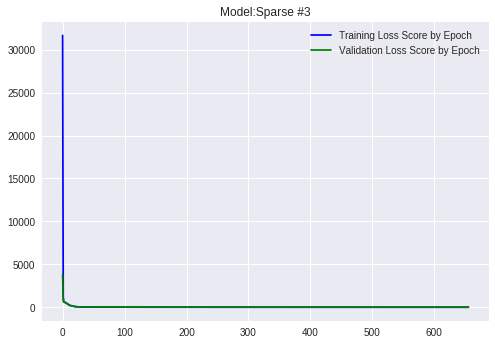

In [153]:
name = 'Model:Sparse #3'
history = sparse_3_history
plot_loss(name, history)

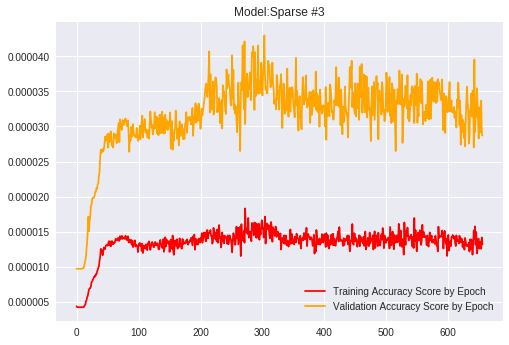

In [154]:
plot_accuracy(name, history)

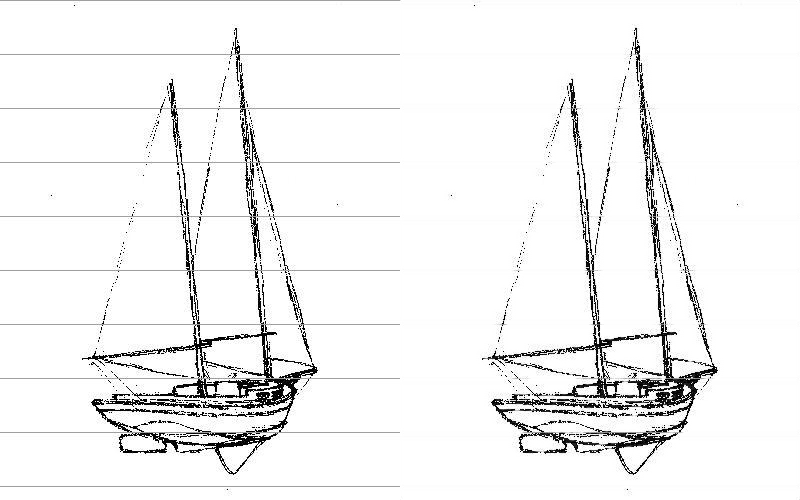

In [155]:
predict_image_on_X(sparse_3)


In [34]:
file_paths = ['Data/Original_Ruled/IMG_0003.jpg', 'Data/Original_Ruled/IMG_0005.jpg',
              'Data/Original_Ruled/IMG_0008.jpg','Data/Original_Ruled/IMG_0012.jpg',
              'Data/Original_Ruled/IMG_0035.jpg','Data/Original_Ruled/IMG_0042.jpg',
              'Data/Original_Ruled/IMG_0045.jpg','Data/Original_Ruled/IMG_0296.jpg',
              'Data/Original_Ruled/Sketch60s_0095.jpg']
#file_path = 'Data/Original_Ruled/IMG_0003.jpg'
unseen = predict_on_unseen(sparse_2, file_paths)

len(unseen)

9

In [35]:
#unseen[0]

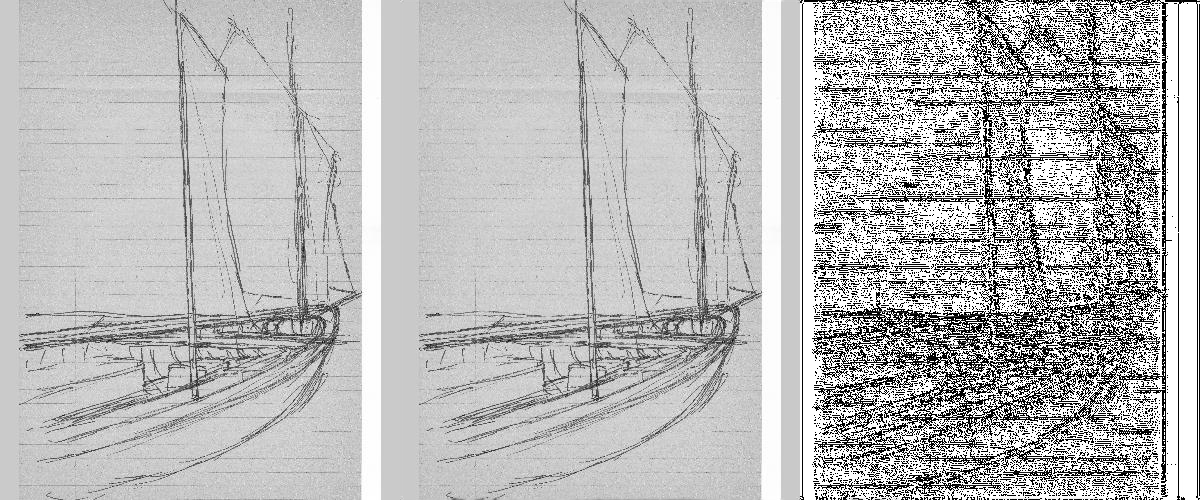

In [36]:
unseen[1]

In [37]:
#unseen[2]

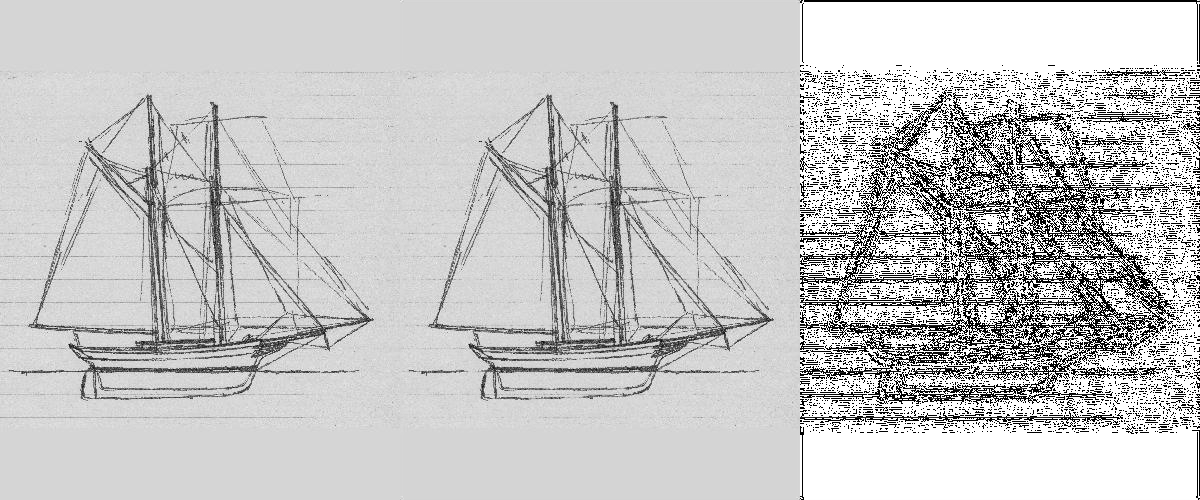

In [38]:
unseen[3]

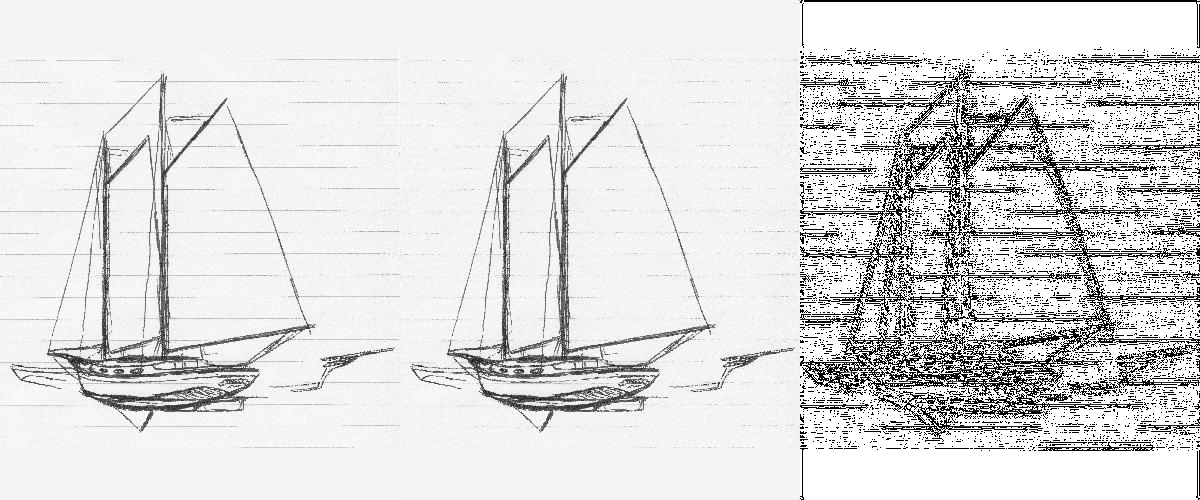

In [39]:
unseen[4]

In [40]:
#unseen[5]

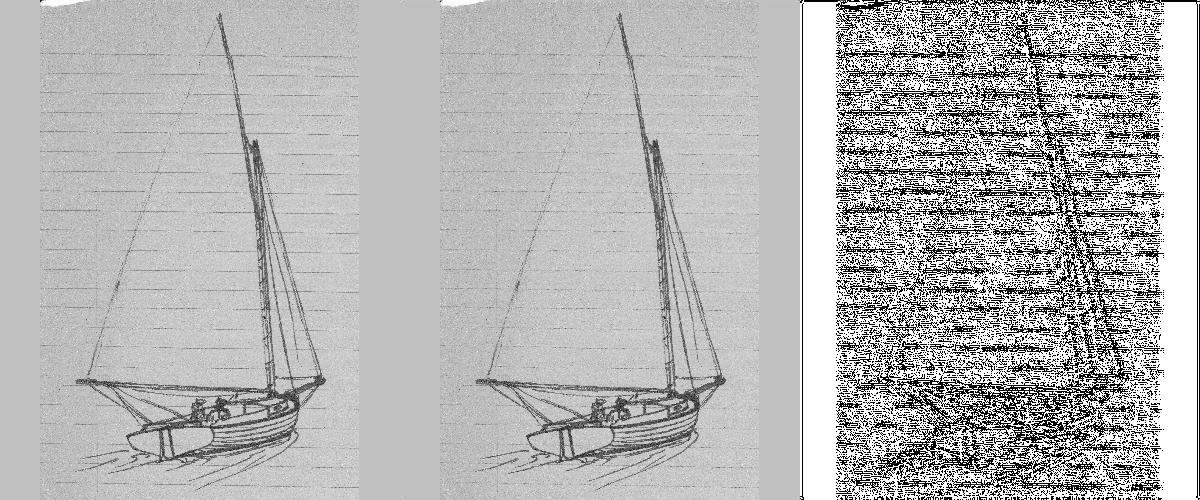

In [41]:
unseen[6]

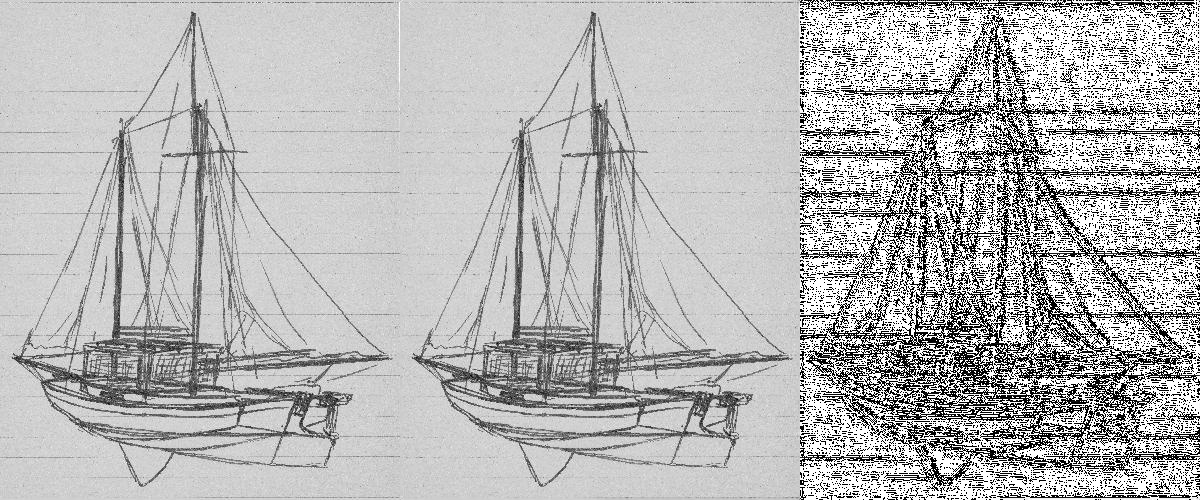

In [42]:
unseen[7]# next try - save this 'enhanced' figure - then apply this model to the enhanced figure - see results

Question for Land - or anyone - how do i get score for (# of same value of pixels/total value of pixels) = difference in pixel colors: image 1(ex. (pixel color = range (0-256)) v pixel location

## Model Type 2: Sequential

In [169]:
#set up model callbacks
tensorboard, early_stopping, model_cp = callbacks(model_name = 'Sequential_3', 
                                                  early_stopping = True, patience = 40)

#create and compile model
Sequential_3 = sequential_model(loss = 'mse', optimizer = 'adamax',
                                metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 498, 398, 32)      320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 496, 396, 32)      9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 494, 394, 32)      9248      
_________________________________________________________________
dense_11 (Dense)             (None, 494, 394, 128)     4224      
_________________________________________________________________
bottleneck (Dense)           (None, 494, 394, 2)       258       
_________________________________________________________________
dense_12 (Dense)             (None, 494, 394, 128)     384       
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 496, 396, 32)     

In [186]:
Sequential_3_history = fit_model(Sequential_3, x=X, y=y, batch_size=15, epochs=5000, verbose=1, 
                             callbacks=[tensorboard, early_stopping, model_cp], 
                             validation_split=0.2)

Epoch 1/5000
36/36 [==============================] - 9s 242ms/step - loss: 18516.3438 - accuracy: 4.5421e-06 - val_loss: 1408.5901 - val_accuracy: 9.7388e-06
Epoch 2/5000
36/36 [==============================] - 8s 233ms/step - loss: 1192.7424 - accuracy: 4.2617e-06 - val_loss: 1131.3051 - val_accuracy: 9.7388e-06
Epoch 3/5000
36/36 [==============================] - 8s 234ms/step - loss: 969.4823 - accuracy: 4.2617e-06 - val_loss: 886.4574 - val_accuracy: 9.7388e-06
Epoch 4/5000
36/36 [==============================] - 8s 233ms/step - loss: 681.1205 - accuracy: 4.2617e-06 - val_loss: 546.5143 - val_accuracy: 9.7388e-06
Epoch 5/5000
36/36 [==============================] - 8s 234ms/step - loss: 425.0649 - accuracy: 4.2617e-06 - val_loss: 366.4916 - val_accuracy: 9.7388e-06
Epoch 6/5000
36/36 [==============================] - 8s 233ms/step - loss: 297.3033 - accuracy: 4.2617e-06 - val_loss: 261.2030 - val_accuracy: 9.7388e-06
Epoch 7/5000
36/36 [==============================] - 8s 23

Epoch 52/5000
36/36 [==============================] - 8s 235ms/step - loss: 15.9622 - accuracy: 1.2495e-05 - val_loss: 16.3158 - val_accuracy: 2.5336e-05
Epoch 53/5000
36/36 [==============================] - 8s 236ms/step - loss: 14.8139 - accuracy: 1.2271e-05 - val_loss: 15.6007 - val_accuracy: 2.7836e-05
Epoch 54/5000
36/36 [==============================] - 8s 235ms/step - loss: 15.1645 - accuracy: 1.0850e-05 - val_loss: 15.7035 - val_accuracy: 3.0261e-05
Epoch 55/5000
36/36 [==============================] - 8s 236ms/step - loss: 16.0916 - accuracy: 1.0308e-05 - val_loss: 16.1713 - val_accuracy: 4.0261e-05
Epoch 56/5000
36/36 [==============================] - 8s 235ms/step - loss: 16.0969 - accuracy: 1.2738e-05 - val_loss: 16.3727 - val_accuracy: 3.1978e-05
Epoch 57/5000
36/36 [==============================] - 8s 236ms/step - loss: 15.5588 - accuracy: 8.1776e-06 - val_loss: 15.3968 - val_accuracy: 3.3731e-05
Epoch 58/5000
36/36 [==============================] - 8s 235ms/step -

Epoch 105/5000
36/36 [==============================] - 8s 236ms/step - loss: 12.1812 - accuracy: 1.5103e-05 - val_loss: 11.7076 - val_accuracy: 3.8396e-05
Epoch 106/5000
36/36 [==============================] - 8s 235ms/step - loss: 11.2621 - accuracy: 1.4981e-05 - val_loss: 11.5123 - val_accuracy: 3.2575e-05
Epoch 107/5000
36/36 [==============================] - 8s 236ms/step - loss: 12.3828 - accuracy: 1.6822e-05 - val_loss: 15.0132 - val_accuracy: 2.5075e-05
Epoch 108/5000
36/36 [==============================] - 8s 235ms/step - loss: 17.8852 - accuracy: 1.5178e-05 - val_loss: 35.5290 - val_accuracy: 2.0746e-05
Epoch 109/5000
36/36 [==============================] - 8s 236ms/step - loss: 15.2815 - accuracy: 1.2654e-05 - val_loss: 14.1502 - val_accuracy: 3.8619e-05
Epoch 110/5000
36/36 [==============================] - 8s 235ms/step - loss: 18.4034 - accuracy: 1.3206e-05 - val_loss: 13.5691 - val_accuracy: 3.0373e-05
Epoch 111/5000
36/36 [==============================] - 8s 236ms

Epoch 210/5000
36/36 [==============================] - 8s 235ms/step - loss: 12.1228 - accuracy: 1.2561e-05 - val_loss: 19.6771 - val_accuracy: 2.5037e-05
Epoch 211/5000
36/36 [==============================] - 8s 236ms/step - loss: 14.4271 - accuracy: 2.6907e-05 - val_loss: 10.1592 - val_accuracy: 1.9030e-05
Epoch 212/5000
36/36 [==============================] - 8s 235ms/step - loss: 9.4497 - accuracy: 1.3150e-05 - val_loss: 9.5267 - val_accuracy: 3.7276e-05
Epoch 213/5000
36/36 [==============================] - 8s 236ms/step - loss: 10.4549 - accuracy: 1.1533e-05 - val_loss: 18.4928 - val_accuracy: 5.9701e-05
Epoch 214/5000
36/36 [==============================] - 8s 235ms/step - loss: 14.9759 - accuracy: 1.7224e-05 - val_loss: 11.0534 - val_accuracy: 3.9179e-05
Epoch 215/5000
36/36 [==============================] - 8s 236ms/step - loss: 9.4108 - accuracy: 1.6393e-05 - val_loss: 9.2680 - val_accuracy: 4.2537e-05
Epoch 216/5000
36/36 [==============================] - 8s 235ms/ste

Epoch 260/5000
36/36 [==============================] - 8s 235ms/step - loss: 8.8593 - accuracy: 1.9523e-05 - val_loss: 15.6185 - val_accuracy: 3.8060e-05
Epoch 261/5000
36/36 [==============================] - 8s 236ms/step - loss: 16.2654 - accuracy: 1.0804e-05 - val_loss: 10.3308 - val_accuracy: 6.6306e-05
Epoch 262/5000
36/36 [==============================] - 8s 235ms/step - loss: 9.8206 - accuracy: 2.2963e-05 - val_loss: 8.8935 - val_accuracy: 3.4590e-05
Epoch 263/5000
36/36 [==============================] - 8s 236ms/step - loss: 10.7102 - accuracy: 1.4907e-05 - val_loss: 15.2213 - val_accuracy: 5.2500e-05
Epoch 264/5000
36/36 [==============================] - 8s 235ms/step - loss: 11.8287 - accuracy: 2.1486e-05 - val_loss: 9.2742 - val_accuracy: 5.5560e-05
Epoch 265/5000
36/36 [==============================] - 8s 235ms/step - loss: 14.2204 - accuracy: 1.8748e-05 - val_loss: 12.6396 - val_accuracy: 4.7052e-05
Epoch 266/5000
36/36 [==============================] - 8s 235ms/ste

Epoch 307/5000
36/36 [==============================] - 8s 236ms/step - loss: 12.3504 - accuracy: 1.1103e-05 - val_loss: 11.8824 - val_accuracy: 6.0560e-05
Epoch 308/5000
36/36 [==============================] - 8s 235ms/step - loss: 8.3374 - accuracy: 1.8495e-05 - val_loss: 8.5768 - val_accuracy: 4.5709e-05
Epoch 309/5000
36/36 [==============================] - 8s 236ms/step - loss: 8.6924 - accuracy: 1.6523e-05 - val_loss: 10.8216 - val_accuracy: 3.7127e-05
Epoch 310/5000
36/36 [==============================] - 8s 235ms/step - loss: 14.2452 - accuracy: 1.5598e-05 - val_loss: 13.5545 - val_accuracy: 3.9030e-05
Epoch 311/5000
36/36 [==============================] - 8s 236ms/step - loss: 8.8519 - accuracy: 1.7009e-05 - val_loss: 9.1395 - val_accuracy: 3.1493e-05
Epoch 312/5000
36/36 [==============================] - 8s 235ms/step - loss: 8.9520 - accuracy: 1.9084e-05 - val_loss: 8.1476 - val_accuracy: 3.6866e-05
Epoch 313/5000
36/36 [==============================] - 8s 235ms/step -

Epoch 355/5000
36/36 [==============================] - 8s 236ms/step - loss: 8.1705 - accuracy: 1.3495e-05 - val_loss: 8.1095 - val_accuracy: 3.4963e-05
Epoch 356/5000
36/36 [==============================] - 10s 289ms/step - loss: 7.4316 - accuracy: 1.8374e-05 - val_loss: 8.0291 - val_accuracy: 4.8321e-05
Epoch 357/5000
36/36 [==============================] - 8s 236ms/step - loss: 7.5002 - accuracy: 1.6757e-05 - val_loss: 8.0694 - val_accuracy: 3.3657e-05
Epoch 358/5000
36/36 [==============================] - 8s 235ms/step - loss: 7.5227 - accuracy: 1.7364e-05 - val_loss: 8.7352 - val_accuracy: 4.2836e-05
Epoch 359/5000
36/36 [==============================] - 8s 236ms/step - loss: 7.7762 - accuracy: 1.6393e-05 - val_loss: 7.9173 - val_accuracy: 4.4179e-05
Epoch 360/5000
36/36 [==============================] - 8s 235ms/step - loss: 7.8453 - accuracy: 1.9935e-05 - val_loss: 9.1790 - val_accuracy: 4.2799e-05
Epoch 361/5000
36/36 [==============================] - 8s 235ms/step - los

Epoch 404/5000
36/36 [==============================] - 8s 235ms/step - loss: 10.9021 - accuracy: 2.5327e-05 - val_loss: 8.4039 - val_accuracy: 2.9590e-05
Epoch 405/5000
36/36 [==============================] - 8s 236ms/step - loss: 7.2318 - accuracy: 1.2486e-05 - val_loss: 8.3227 - val_accuracy: 4.7052e-05
Epoch 406/5000
36/36 [==============================] - 8s 235ms/step - loss: 7.3789 - accuracy: 1.7421e-05 - val_loss: 7.7389 - val_accuracy: 4.6679e-05
Epoch 407/5000
36/36 [==============================] - 8s 236ms/step - loss: 7.6349 - accuracy: 2.4458e-05 - val_loss: 8.0388 - val_accuracy: 2.7052e-05
Epoch 408/5000
36/36 [==============================] - 8s 235ms/step - loss: 7.9483 - accuracy: 1.3738e-05 - val_loss: 8.5883 - val_accuracy: 3.0821e-05
Epoch 409/5000
36/36 [==============================] - 8s 236ms/step - loss: 10.4856 - accuracy: 1.9150e-05 - val_loss: 14.5792 - val_accuracy: 2.5187e-05
Epoch 410/5000
36/36 [==============================] - 8s 235ms/step - l

Epoch 452/5000
36/36 [==============================] - 8s 235ms/step - loss: 9.0037 - accuracy: 1.7047e-05 - val_loss: 9.4873 - val_accuracy: 4.7649e-05
Epoch 453/5000
36/36 [==============================] - 8s 236ms/step - loss: 7.4383 - accuracy: 1.3037e-05 - val_loss: 7.8762 - val_accuracy: 4.7127e-05
Epoch 454/5000
36/36 [==============================] - 8s 235ms/step - loss: 7.2840 - accuracy: 1.9645e-05 - val_loss: 7.7831 - val_accuracy: 4.9104e-05
Epoch 455/5000
36/36 [==============================] - 8s 236ms/step - loss: 7.2678 - accuracy: 1.7579e-05 - val_loss: 7.6994 - val_accuracy: 3.0746e-05
Epoch 456/5000
36/36 [==============================] - 8s 235ms/step - loss: 9.1670 - accuracy: 1.7766e-05 - val_loss: 20.2053 - val_accuracy: 7.3507e-05
Epoch 457/5000
36/36 [==============================] - 8s 236ms/step - loss: 9.4230 - accuracy: 1.7523e-05 - val_loss: 7.9538 - val_accuracy: 3.8769e-05
Epoch 458/5000
36/36 [==============================] - 8s 235ms/step - los

Epoch 500/5000
36/36 [==============================] - 8s 235ms/step - loss: 6.7777 - accuracy: 1.8234e-05 - val_loss: 7.6230 - val_accuracy: 4.4552e-05
Epoch 501/5000
36/36 [==============================] - 8s 236ms/step - loss: 8.2076 - accuracy: 1.8336e-05 - val_loss: 8.3805 - val_accuracy: 3.9179e-05
Epoch 502/5000
36/36 [==============================] - 8s 235ms/step - loss: 11.6844 - accuracy: 2.0383e-05 - val_loss: 11.5235 - val_accuracy: 4.0709e-05
Epoch 503/5000
36/36 [==============================] - 8s 236ms/step - loss: 7.5199 - accuracy: 1.7579e-05 - val_loss: 7.5512 - val_accuracy: 4.3284e-05
Epoch 504/5000
36/36 [==============================] - 8s 235ms/step - loss: 6.7029 - accuracy: 1.8991e-05 - val_loss: 7.2292 - val_accuracy: 4.3172e-05
Epoch 505/5000
36/36 [==============================] - 10s 291ms/step - loss: 6.6857 - accuracy: 1.8523e-05 - val_loss: 7.7282 - val_accuracy: 4.3694e-05
Epoch 506/5000
36/36 [==============================] - 8s 235ms/step - l

Epoch 550/5000
36/36 [==============================] - 8s 235ms/step - loss: 6.6415 - accuracy: 1.6327e-05 - val_loss: 7.1173 - val_accuracy: 5.6716e-05
Epoch 551/5000
36/36 [==============================] - 8s 236ms/step - loss: 7.0081 - accuracy: 2.1374e-05 - val_loss: 7.3678 - val_accuracy: 4.7500e-05
Epoch 552/5000
36/36 [==============================] - 8s 235ms/step - loss: 8.1973 - accuracy: 9.8598e-06 - val_loss: 7.0502 - val_accuracy: 5.5000e-05
Epoch 553/5000
36/36 [==============================] - 8s 236ms/step - loss: 9.6997 - accuracy: 2.2421e-05 - val_loss: 7.7727 - val_accuracy: 6.1082e-05
Epoch 554/5000
36/36 [==============================] - 8s 235ms/step - loss: 6.6163 - accuracy: 1.8374e-05 - val_loss: 6.9651 - val_accuracy: 4.4478e-05
Epoch 555/5000
36/36 [==============================] - 10s 282ms/step - loss: 6.4656 - accuracy: 2.0589e-05 - val_loss: 7.3374 - val_accuracy: 3.6119e-05
Epoch 556/5000
36/36 [==============================] - 8s 235ms/step - los

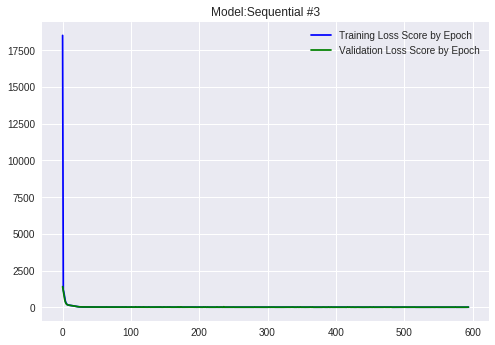

In [187]:
name = 'Model:Sequential #3'
plot_loss(name, Sequential_3_history)

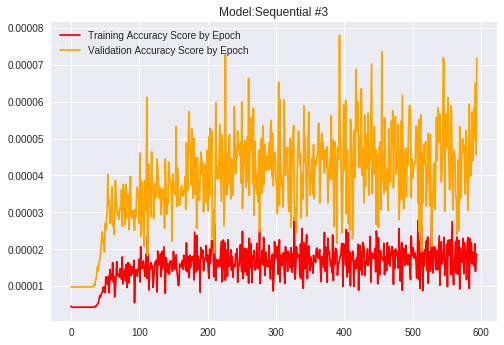

In [188]:
plot_accuracy(name, Sequential_3_history)

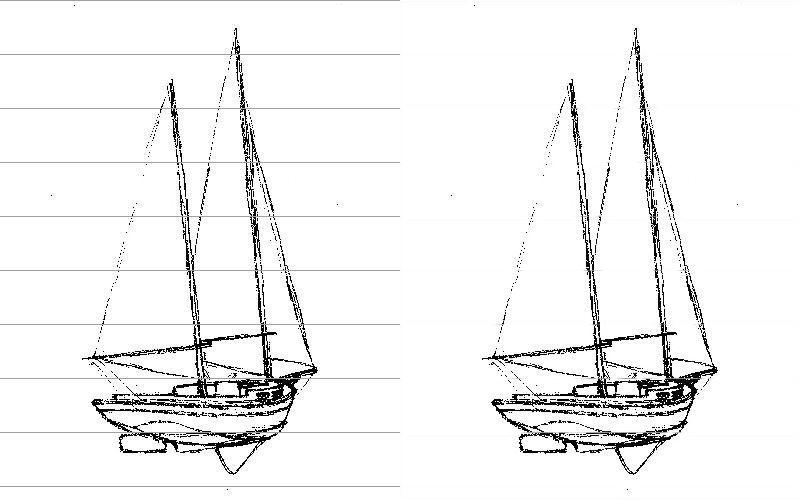

In [189]:
predict_image_on_X(Sequential_3)

In [49]:
file_paths = ['Data/Original_Ruled/IMG_0003.jpg', 'Data/Original_Ruled/IMG_0005.jpg',
              'Data/Original_Ruled/IMG_0008.jpg','Data/Original_Ruled/IMG_0012.jpg',
              'Data/Original_Ruled/IMG_0035.jpg','Data/Original_Ruled/IMG_0042.jpg',
              'Data/Original_Ruled/IMG_0045.jpg','Data/Original_Ruled/IMG_0296.jpg',
              'Data/Original_Ruled/Sketch60s_0095.jpg']
#file_path = 'Data/Original_Ruled/IMG_0003.jpg'
Seq_1_unseen = predict_on_unseen(Seq_1, file_paths)

len(Seq_1_unseen)

9

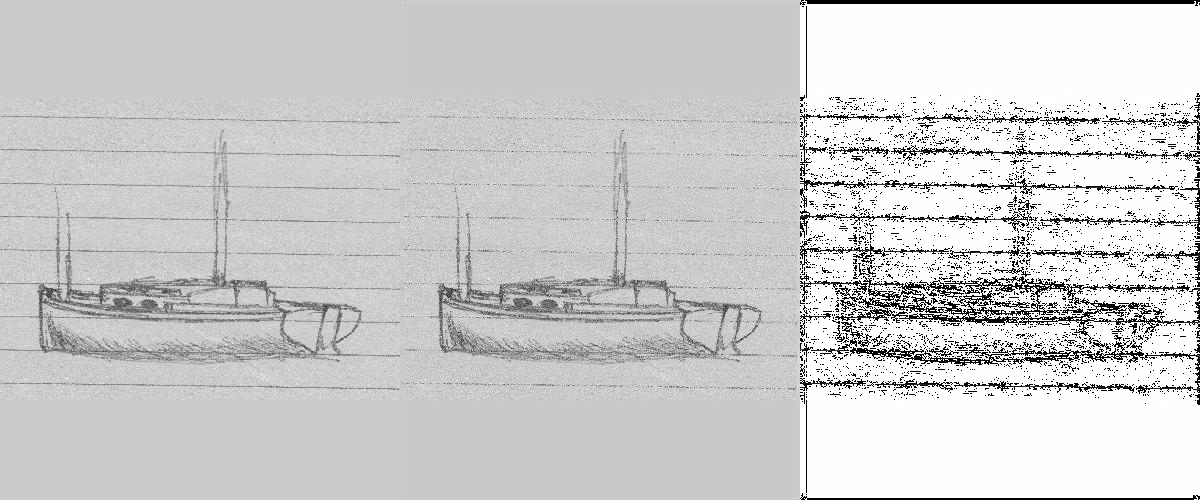

In [50]:
Seq_1_unseen[0]

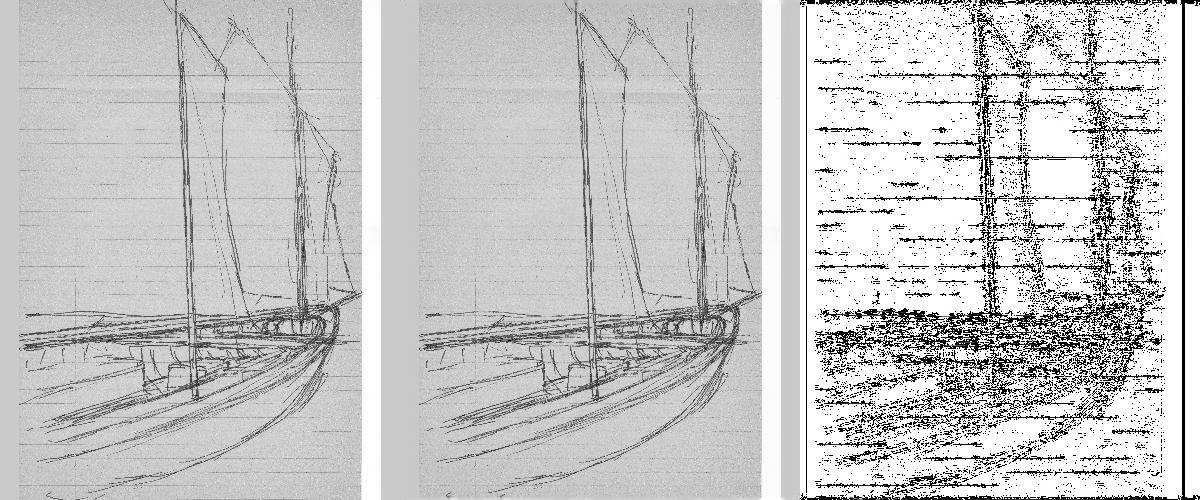

In [51]:
Seq_1_unseen[1]

In [52]:
#Seq_3_unseen[2]

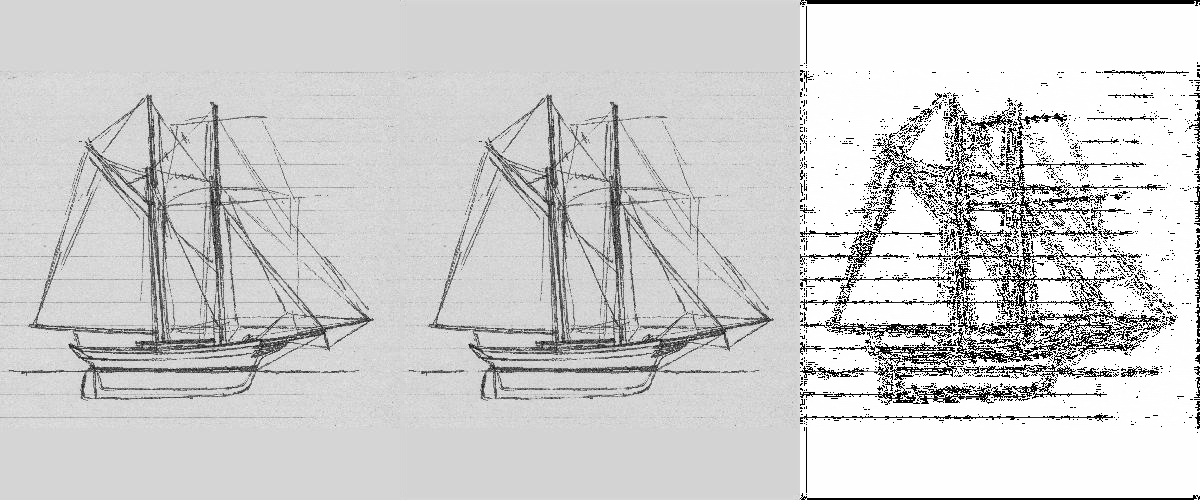

In [53]:
Seq_1_unseen[3]

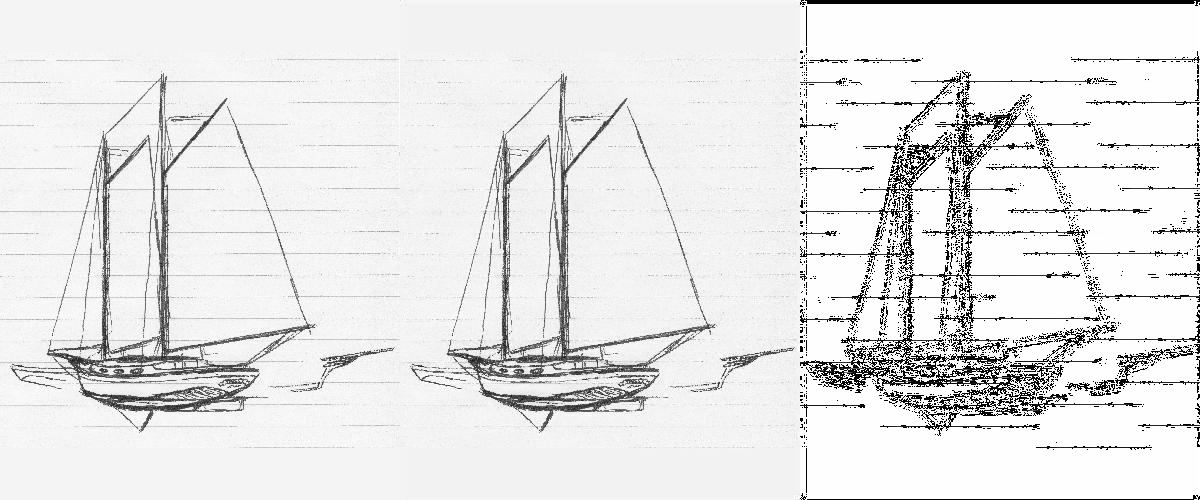

In [54]:
Seq_1_unseen[4]

In [55]:
#Seq_3_unseen[5]

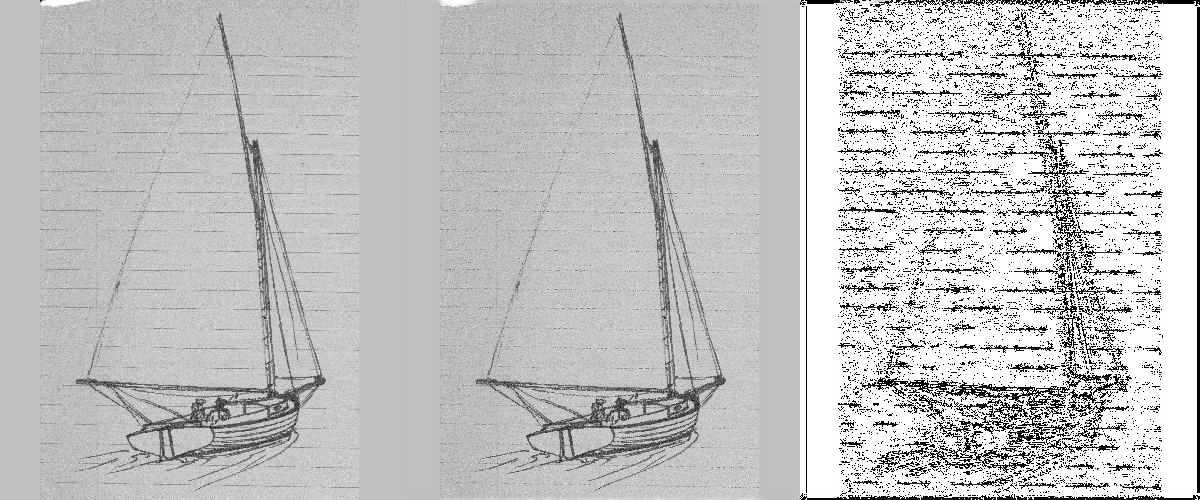

In [56]:
Seq_1_unseen[6]

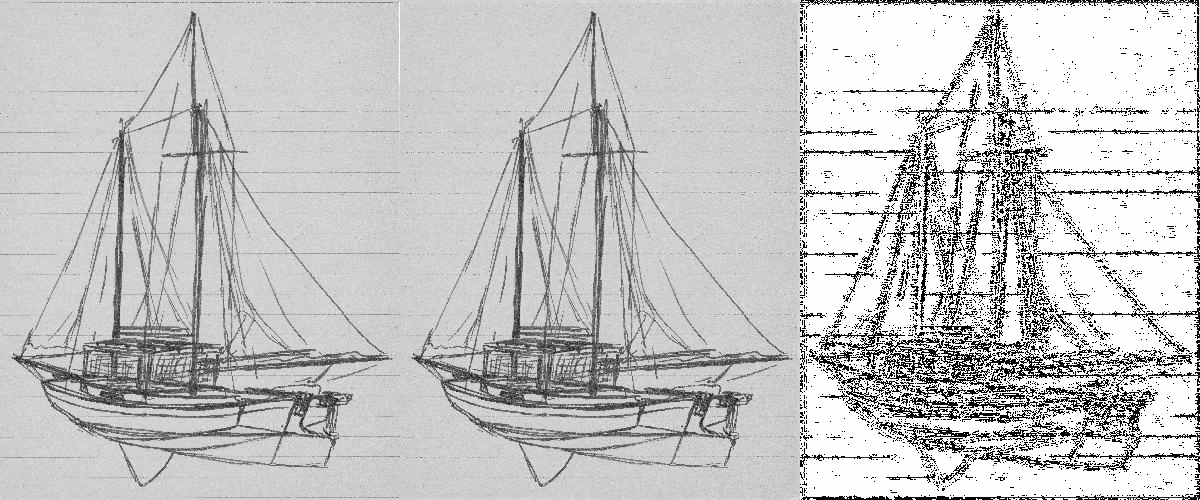

In [57]:
Seq_1_unseen[7]

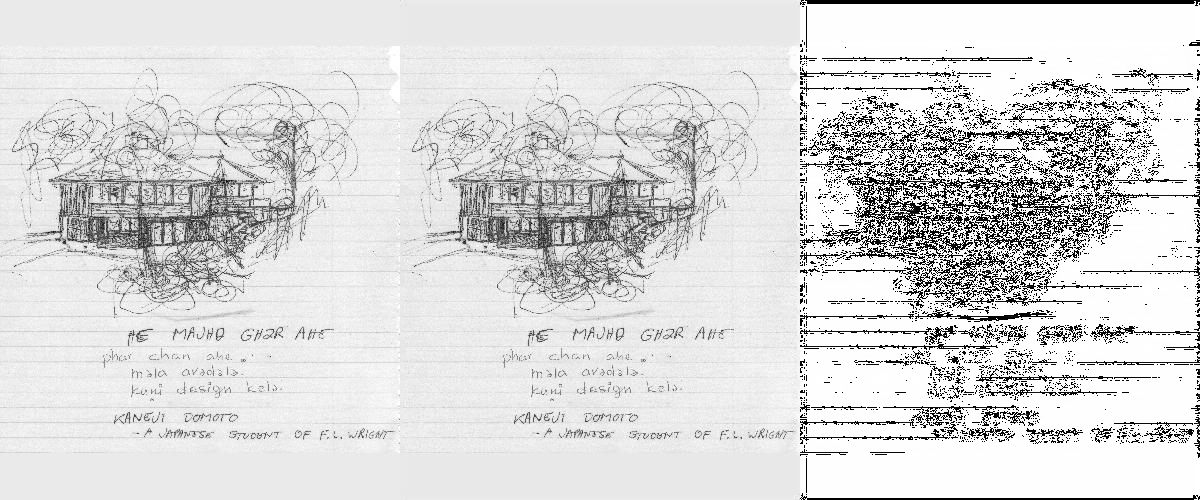

In [58]:
Seq_1_unseen[8]

# Multi run on same image

In [20]:
image_to_predict = np.array(Image.open('Data/Original_Ruled/Sketch60s_0095.jpg'))

In [31]:
multi_run_result = image_to_predict.reshape(1,500,400,1)

for i in range(5):
    multi_run_result = Seq_1.predict(multi_run_result)
    multi_run_result = sparse_1.predict(multi_run_result)
    multi_run_result = Seq_2.predict(multi_run_result)
    multi_run_result = sparse_2.predict(multi_run_result)
    #multi_run_result = sparse_3_adamax(multi_run_result)
    #multi_run_result = Seq_3_adamax(multi_run_result)

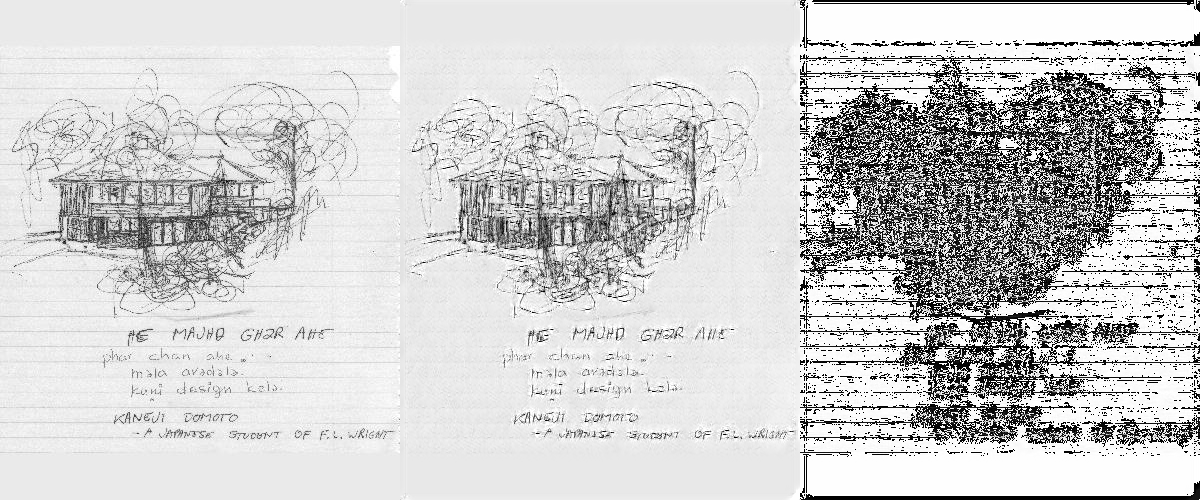

In [32]:


multi_run_result[multi_run_result>255]=255
multi_run_result[multi_run_result<0] = 0
result = multi_run_result.astype(np.uint8).reshape(500,400)
original = image_to_predict.astype(np.uint8).reshape(500,400)
difference = result - original   
Image.fromarray(np.hstack([original, result, difference]))

# Evaluate saved models 

In [37]:
# bring back model if lost
# sparse_3 = open_saved_model('sparse_3')


## Sparse Model Results:

In [14]:
sparse_1 = open_saved_model('sparse_1')
sparse_1.evaluate(X,y, return_dict=True)


21/21 [==============================] - 2s 81ms/step - loss: 8.8567 - accuracy: 1.8827e-05


{'loss': 8.856674194335938, 'accuracy': 1.8826607629307546e-05}

In [15]:
sparse_2 = open_saved_model('sparse_2')
sparse_2.evaluate(X,y, return_dict=True)

21/21 [==============================] - 1s 67ms/step - loss: 9.6267 - accuracy: 2.0501e-05


{'loss': 9.626681327819824, 'accuracy': 2.050074726867024e-05}

In [16]:
sparse_3_adamax =open_saved_model('sparse_3')
sparse_3_adamax.evaluate(X,y, return_dict=True)


21/21 [==============================] - 1s 67ms/step - loss: 8.3549 - accuracy: 1.9096e-05


{'loss': 8.354877471923828, 'accuracy': 1.9095665265922435e-05}

## Sequential Model Results:

In [17]:
Seq_1 = open_saved_model('Sequential_1')
Seq_1.evaluate(X,y, return_dict=True)


21/21 [==============================] - 4s 183ms/step - loss: 13.3236 - accuracy: 2.2085e-05


{'loss': 13.323619842529297, 'accuracy': 2.2085201635491103e-05}

In [18]:
Seq_2 = open_saved_model('Sequential_2')
Seq_2.evaluate(X,y, return_dict=True)


21/21 [==============================] - 3s 161ms/step - loss: 9.6326 - accuracy: 1.9268e-05


{'loss': 9.632638931274414, 'accuracy': 1.9267563402536325e-05}

In [19]:
Seq_3_adamax = open_saved_model('Sequential_3')
Seq_3_adamax.evaluate(X,y, return_dict=True)


21/21 [==============================] - 3s 161ms/step - loss: 6.9212 - accuracy: 1.9043e-05


{'loss': 6.921177387237549, 'accuracy': 1.904334749269765e-05}

JUNK BELOW THIS LINE:

In [ ]:
image_to_predict = np.array(Image.open('Data/Original_Ruled/IMG_0003.jpg'))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(scharr)
ax[0].set_title('Scharr')
ax[0].axis('off')

ax[1].imshow(scharr_h)
ax[1].set_title('Scharr Horizontal')
ax[1].axis('off')

ax[2].imshow(scharr_v)
ax[2].set_title('Scharr Vertical')
ax[2].axis('off')
